In [1]:
import tensorflow as tf
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
!pip install transformers
!pip install tensorflow_addons
!pip install --quiet vit-keras

In [3]:
##The with statement is used to create a block of code within which the file is opened and accessed.
import pandas as pd
file_path = '/kaggle/input/flickr8k/captions.txt'
image_ids = []
captions = []
df = pd.DataFrame()
with open(file_path,'r') as f:
    for line in f:
        line.strip()
        image_id , caption = line.split(",",1)
        image_ids.append(image_id)
        captions.append(caption)
df["Image_ID"] = image_ids
df["Caption"] = captions
df.head(10)

Image_ID  \
0                      image   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1000268201_693b08cb0e.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             Caption  
0                                          caption\n  
1  A child in a pink dress is climbing up a set o...  
2            A girl going into a wooden building .\n  
3  A little girl climbing into a wooden playhouse...  
4  A little girl climbing the stairs to her playh...  
5  A little girl in a pink dress going into a woo...  
6       A black dog and a spotted dog are fighting\n  
7  A black dog and a tri-colored dog playing with...  
8  A black dog and a white dog with brown spots a...  
9  Two dogs of different breeds looking at each o...

In [4]:
df.drop(df.index[0],inplace = True)
df.head()

Image_ID  \
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1000268201_693b08cb0e.jpg   

                                             Caption  
1  A child in a pink dress is climbing up a set o...  
2            A girl going into a wooden building .\n  
3  A little girl climbing into a wooden playhouse...  
4  A little girl climbing the stairs to her playh...  
5  A little girl in a pink dress going into a woo...

In [5]:
import re

def pre_processing(text,col):
    text = re.sub("[^a-zA-Z\s]" ,' ',text.lower()).strip()
    if(col == 0):
        text = '<start> ' + text + ' <end>'
    elif(col == 1):
        text = '<start> ' + text
    elif(col == 2):
        text = text + ' <end>'
    return text

In [6]:
df['preprocessed_caption'] = df['Caption'].apply(pre_processing, col = 0)
df['tar_inp'] = df['Caption'].apply(pre_processing, col = 1)
df['tar_pred'] = df['Caption'].apply(pre_processing, col = 2)

df.head()

Image_ID  \
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1000268201_693b08cb0e.jpg   

                                             Caption  \
1  A child in a pink dress is climbing up a set o...   
2            A girl going into a wooden building .\n   
3  A little girl climbing into a wooden playhouse...   
4  A little girl climbing the stairs to her playh...   
5  A little girl in a pink dress going into a woo...   

                                preprocessed_caption  \
1  <start> a child in a pink dress is climbing up...   
2  <start> a girl going into a wooden building <end>   
3  <start> a little girl climbing into a wooden p...   
4  <start> a little girl climbing the stairs to h...   
5  <start> a little girl in a pink dress going in...   

                                             tar_inp  \
1  <start> a child in a pink dress is climbing up...   
2        <start> a girl going into a wooden building   
3  <start> a little girl climbing into a wooden p...   
4  <start> a little girl climbing the stairs to h...   
5  <start> a little girl in a pink dress going in...   

                                            tar_pred  
1  a child in a pink dress is climbing up a set o...  
2          a girl going into a wooden building <end>  
3  a little girl climbing into a wooden playhouse...  
4  a little girl climbing the stairs to her playh...  
5  a little girl in a pink dress going into a woo...

In [7]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['preprocessed_caption'])
vocab_size = len(tokenizer.word_index)+1

cap_vec_inp = tokenizer.texts_to_sequences(df['tar_inp'])
cap_vec_pred = tokenizer.texts_to_sequences(df['tar_pred'])

print(vocab_size)

8442


In [8]:
from keras.utils import pad_sequences

print('Max sentence length: ', max([len(sen) for sen in cap_vec_inp]))
MAX_LEN = 48

cap_vec_inp = pad_sequences(cap_vec_inp , maxlen = MAX_LEN ,dtype = "long" , value = 0, padding = "post")
cap_vec_pred = pad_sequences(cap_vec_pred , maxlen = MAX_LEN ,dtype = "long" , value = 0, padding = "post")

print(cap_vec_inp)
print(cap_vec_pred)

Max sentence length:  37
[[ 3  1 43 ...  0  0  0]
 [ 3  1 19 ...  0  0  0]
 [ 3  1 40 ...  0  0  0]
 ...
 [ 3  1 44 ...  0  0  0]
 [ 3  1 85 ...  0  0  0]
 [ 3  1 85 ...  0  0  0]]
[[  1  43   4 ...   0   0   0]
 [  1  19 316 ...   0   0   0]
 [  1  40  19 ...   0   0   0]
 ...
 [  1  44   4 ...   0   0   0]
 [  1  85 357 ...   0   0   0]
 [  1  85 357 ...   0   0   0]]


In [9]:
print(cap_vec_inp.shape)

(40455, 48)


In [10]:
import collections

image_path_to_caption = collections.defaultdict(list)
for i in df.index:
    image_path = '/kaggle/input/flickr8k/Images/' + df['Image_ID'][i]
    image_path_to_caption[image_path].append(df['preprocessed_caption'][i])

print(image_path_to_caption)

image_paths = list(image_path_to_caption.keys())
print(len(image_paths))

defaultdict(<class 'list'>, {'/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg': ['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>', '<start> a girl going into a wooden building <end>', '<start> a little girl climbing into a wooden playhouse <end>', '<start> a little girl climbing the stairs to her playhouse <end>', '<start> a little girl in a pink dress going into a wooden cabin <end>'], '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg': ['<start> a black dog and a spotted dog are fighting <end>', '<start> a black dog and a tri colored dog playing with each other on the road <end>', '<start> a black dog and a white dog with brown spots are staring at each other in the street <end>', '<start> two dogs of different breeds looking at each other on the road <end>', '<start> two dogs on pavement moving toward each other <end>'], '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg': ['<start> a little girl covered in paint sits in fro

In [11]:
train_captions = []
img_name_vector = []

for image_path in image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

df['img_path'] = img_name_vector
df.head(10)

Image_ID  \
1   1000268201_693b08cb0e.jpg   
2   1000268201_693b08cb0e.jpg   
3   1000268201_693b08cb0e.jpg   
4   1000268201_693b08cb0e.jpg   
5   1000268201_693b08cb0e.jpg   
6   1001773457_577c3a7d70.jpg   
7   1001773457_577c3a7d70.jpg   
8   1001773457_577c3a7d70.jpg   
9   1001773457_577c3a7d70.jpg   
10  1001773457_577c3a7d70.jpg   

                                              Caption  \
1   A child in a pink dress is climbing up a set o...   
2             A girl going into a wooden building .\n   
3   A little girl climbing into a wooden playhouse...   
4   A little girl climbing the stairs to her playh...   
5   A little girl in a pink dress going into a woo...   
6        A black dog and a spotted dog are fighting\n   
7   A black dog and a tri-colored dog playing with...   
8   A black dog and a white dog with brown spots a...   
9   Two dogs of different breeds looking at each o...   
10  Two dogs on pavement moving toward each other .\n   

                                 preprocessed_caption  \
1   <start> a child in a pink dress is climbing up...   
2   <start> a girl going into a wooden building <end>   
3   <start> a little girl climbing into a wooden p...   
4   <start> a little girl climbing the stairs to h...   
5   <start> a little girl in a pink dress going in...   
6   <start> a black dog and a spotted dog are figh...   
7   <start> a black dog and a tri colored dog play...   
8   <start> a black dog and a white dog with brown...   
9   <start> two dogs of different breeds looking a...   
10  <start> two dogs on pavement moving toward eac...   

                                              tar_inp  \
1   <start> a child in a pink dress is climbing up...   
2         <start> a girl going into a wooden building   
3   <start> a little girl climbing into a wooden p...   
4   <start> a little girl climbing the stairs to h...   
5   <start> a little girl in a pink dress going in...   
6   <start> a black dog and a spotted dog are figh...   
7   <start> a black dog and a tri colored dog play...   
8   <start> a black dog and a white dog with brown...   
9   <start> two dogs of different breeds looking a...   
10  <start> two dogs on pavement moving toward eac...   

                                             tar_pred  \
1   a child in a pink dress is climbing up a set o...   
2           a girl going into a wooden building <end>   
3   a little girl climbing into a wooden playhouse...   
4   a little girl climbing the stairs to her playh...   
5   a little girl in a pink dress going into a woo...   
6    a black dog and a spotted dog are fighting <end>   
7   a black dog and a tri colored dog playing with...   
8   a black dog and a white dog with brown spots a...   
9   two dogs of different breeds looking at each o...   
10  two dogs on pavement moving toward each other ...   

                                             img_path  
1   /kaggle/input/flickr8k/Images/1000268201_693b0...  
2   /kaggle/input/flickr8k/Images/1000268201_693b0...  
3   /kaggle/input/flickr8k/Images/1000268201_693b0...  
4   /kaggle/input/flickr8k/Images/1000268201_693b0...  
5   /kaggle/input/flickr8k/Images/1000268201_693b0...  
6   /kaggle/input/flickr8k/Images/1001773457_577c3...  
7   /kaggle/input/flickr8k/Images/1001773457_577c3...  
8   /kaggle/input/flickr8k/Images/1001773457_577c3...  
9   /kaggle/input/flickr8k/Images/1001773457_577c3...  
10  /kaggle/input/flickr8k/Images/1001773457_577c3...

<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>


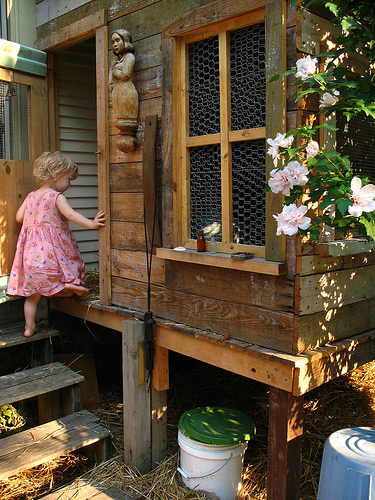

In [12]:
##Sanity Check
from PIL import Image
print(train_captions[0])
Image.open(img_name_vector[0])

In [13]:
from sklearn.model_selection import train_test_split

img_train, img_test, cap_inp_train, cap_inp_test = train_test_split(img_name_vector,cap_vec_inp,random_state=2023,test_size = 0.2)
_, _, cap_pred_train, cap_pred_test = train_test_split(img_name_vector,cap_vec_pred,random_state=2023,test_size = 0.2)


In [14]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    img = img/255
    return img

print(load_image(img_name_vector[0]))

tf.Tensor(
[[[0.27478164 0.30669665 0.35381675]
  [0.416326   0.490792   0.4676667 ]
  [0.48003444 0.5559974  0.5287704 ]
  ...
  [0.00953609 0.00546461 0.00894086]
  [0.01413348 0.02186234 0.01204941]
  [0.0204859  0.03778217 0.0157852 ]]

 [[0.25925386 0.28907844 0.3279944 ]
  [0.42747512 0.5018974  0.49220517]
  [0.49538168 0.57548493 0.5523302 ]
  ...
  [0.02546721 0.03850614 0.0243226 ]
  [0.02526871 0.02919028 0.03288002]
  [0.05111453 0.07815222 0.02740859]]

 [[0.2560796  0.2706005  0.3297987 ]
  [0.44897404 0.5196096  0.51989484]
  [0.4866917  0.57205    0.5532214 ]
  ...
  [0.0222775  0.03086765 0.01062955]
  [0.01203223 0.03864507 0.01127444]
  [0.01075941 0.06733698 0.03296788]]

 ...

 [[0.8300115  0.5644024  0.19729933]
  [0.54837394 0.24331313 0.03300653]
  [0.64854825 0.46670341 0.25919682]
  ...
  [0.8769543  0.8988548  0.9549243 ]
  [0.6271971  0.7181935  0.7893105 ]
  [0.64108264 0.722704   0.7883259 ]]

 [[0.6506623  0.35299784 0.04552959]
  [0.62757707 0.44175196 0

In [15]:
d_model = 512
num_heads = 4
dropout_rate = 0.1
batch_size = 64
dff = 1024
num_layers = 8
max_tokens = 48

In [16]:
from vit_keras import vit
IMAGE_SIZE = 224
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        )

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


353253686/353253686 [==============================] - 2s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [17]:
new_input = vit_model.input
##we dont want the classification output which is the pretraining task for vit-pretraining
hidden_layer = vit_model.layers[-2].output
vision_transformer_model = tf.keras.Model(new_input, hidden_layer)

for layer in vision_transformer_model.layers:
    layer.trainable = False

vision_transformer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))        

In [18]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,d_model,vision_transformer):
        super(Encoder,self).__init__()
        self.vit = vision_transformer
        self.units = d_model
        self.dense = tf.keras.layers.Dense(self.units, activation = tf.nn.gelu)

    def call(self,x,training,mask): ##where are these parameters??
        x = self.vit(x)
        x = self.dense(x)
        return x

In [19]:
##Sanity check for Encoder
img = load_image(img_name_vector[0])
img = tf.expand_dims(img,axis = 0)

sample_encoder = Encoder(d_model,vision_transformer_model)
sample_encoder_output = sample_encoder(img,training=False, mask=None)
print(sample_encoder_output)

tf.Tensor(
[[[-0.1698644   0.53670675 -0.02577641 ...  0.3135493  -0.16976161
    0.04629555]
  [-0.11257882  0.9054557  -0.11253616 ... -0.16992016 -0.16128103
   -0.02664338]
  [-0.10260069  1.0663226  -0.07825655 ... -0.08645084 -0.05468316
   -0.00559542]
  ...
  [-0.11384599  0.7098719  -0.10516798 ...  1.0711993  -0.15257657
   -0.01666415]
  [-0.06581888 -0.05548729 -0.1311255  ...  0.20419048 -0.16949758
   -0.04138545]
  [-0.01892127  0.5464871  -0.16577168 ...  1.5817379   0.09964637
    0.68021065]]], shape=(1, 50, 512), dtype=float32)


In [20]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [21]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [22]:
def positional_encoding(position, d_model):
  ##creates a sqaure matrix of dim seq_lengthxd_model and calculates the angles
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :],d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

 ##add axis for further operations (batch dim)
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [23]:
def scaled_dot_product_attention(q, k, v, mask):
  #print(q.shape,k.shape,v.shape)
    matmul_qk = tf.matmul(q, k, transpose_b=True)
  #print(matmul_qk.shape)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9) ##very small number as mask had 0's and 1's
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    ##all heads can interact with each other and gain context
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [25]:
### Decoder Layer:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask):

    ##self attention with resiude connection,dropout and layer normalization
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

    ##cross attention
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, None)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ##FFN
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [26]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [27]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size, max_tokens,
               rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_tokens =  max_tokens

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_tokens, d_model)
        self.dec_layers = [
              DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
              for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        ##print(x.shape)
    ##Add positional embeddings only for seq length (only max_length)
        x = self.embedding(x)
        ##print(x.shape)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask)
      #store weights of both layers abd keep updating
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights

In [28]:
sample_decoder = Decoder(num_layers=8, d_model=512, num_heads=4,
                         dff=1024, target_vocab_size=vocab_size, max_tokens = 48)
temp_input = tf.random.uniform((1, 48), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              )

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([1, 48, 512]), TensorShape([1, 4, 48, 50]))

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model, num_heads, dff,
               target_vocab_size, vision_transformer, max_tokens, rate=0.1):
        super().__init__()
        self.vision_transformer = vision_transformer
        self.encoder = Encoder(d_model, self.vision_transformer)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, max_tokens=max_tokens, rate=rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        inp, tar = inputs
        look_ahead_mask = self.create_masks(tar)
        enc_output = self.encoder(inp, training, None)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

    def create_look_ahead_mask(self,size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)
    
    def create_padding_mask(self,seq):
        
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
    
    def create_masks(self,tar):
        
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = self.create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return look_ahead_mask



In [30]:
sample_transformer = Transformer(
    num_layers=8, d_model=512, num_heads=4, dff=1024, target_vocab_size=vocab_size, vision_transformer = vision_transformer_model, max_tokens=48)

temp_target = tf.random.uniform((1, 48), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([img, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([1, 48, 8442])

In [31]:
##Warmup and decay based learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d_model,warmup_steps=4000):
        super(CustomSchedule,self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model,tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self,step):
        step = tf.cast(step, tf.float32)  # Convert step to a tf.Tensor of float32 type
        arg1 = tf.math.rsqrt(step)
        arg2 = step*(self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [32]:
learning_rate = CustomSchedule(d_model)
##It computes individual learning rates for different parameters based on estimates of first and second moments of the gradients
optimizer = tf.keras.optimizers.Adam(learning_rate , beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

##apply loss only to unpadded values
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [34]:
##take care of average loss and acc while training
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [35]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    target_vocab_size=vocab_size,
    vision_transformer = vision_transformer_model,
    max_tokens = 48,
    rate=dropout_rate)

In [36]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [37]:
@tf.function
def train_step(inp, tar_inp, tar_pred):

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp],
                                 training = True)
        loss = loss_function(tar_pred, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_pred, predictions))

In [38]:
image_ds = tf.data.Dataset.from_tensor_slices(img_train)
cap_vec_inp = tf.data.Dataset.from_tensor_slices(cap_inp_train)
cap_vec_pred = tf.data.Dataset.from_tensor_slices(cap_pred_train)

image_ds = image_ds.map(load_image)

print(image_ds)
train_batches = tf.data.Dataset.zip((image_ds, cap_vec_inp, cap_vec_pred))
train_batches = train_batches.batch(batch_size).prefetch(tf.data.AUTOTUNE)
for (batch, (inp, tar_inp,tar_pred)) in enumerate(train_batches):
    print(batch)
    print(inp.shape)
    print(tar_inp.shape)
    print(tar_pred.shape)
    break
print(len(train_batches))

<_MapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
0
(64, 224, 224, 3)
(64, 48)
(64, 48)
506


In [39]:
import time

EPOCHS = 6
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
    for (batch, (inp, tar_inp,tar_pred)) in enumerate(train_batches):
    #print(inp, tar)
        train_step(inp, tar_inp,tar_pred)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 9.0372 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.7440 Accuracy 0.0624
Epoch 1 Batch 100 Loss 8.3234 Accuracy 0.0976
Epoch 1 Batch 150 Loss 7.9565 Accuracy 0.1088
Epoch 1 Batch 200 Loss 7.6010 Accuracy 0.1150
Epoch 1 Batch 250 Loss 7.2541 Accuracy 0.1254
Epoch 1 Batch 300 Loss 6.9490 Accuracy 0.1342
Epoch 1 Batch 350 Loss 6.6945 Accuracy 0.1440
Epoch 1 Batch 400 Loss 6.4724 Accuracy 0.1553
Epoch 1 Batch 450 Loss 6.2736 Accuracy 0.1664
Epoch 1 Batch 500 Loss 6.0966 Accuracy 0.1765
Epoch 1 Loss 6.0796 Accuracy 0.1774
Time taken for 1 epoch: 312.00 secs

Epoch 2 Batch 0 Loss 4.4029 Accuracy 0.2797
Epoch 2 Batch 50 Loss 4.3027 Accuracy 0.2865
Epoch 2 Batch 100 Loss 4.2367 Accuracy 0.2898
Epoch 2 Batch 150 Loss 4.1949 Accuracy 0.2934
Epoch 2 Batch 200 Loss 4.1411 Accuracy 0.2976
Epoch 2 Batch 250 Loss 4.0948 Accuracy 0.3011
Epoch 2 Batch 300 Loss 4.0485 Accuracy 0.3053
Epoch 2 Batch 350 Loss 4.0062 Accuracy 0.3089
Epoch 2 Batch 400 Loss 3.9635 Accuracy 0.3124
Epoch 2 Batch

In [40]:
vocabulary = tokenizer.word_index
vocabulary = list(vocabulary)
index_to_word = tf.keras.layers.StringLookup(
    vocabulary=vocabulary,
    invert=True)

In [41]:
import matplotlib.pyplot as plt
def caption_image(image_path, transformer):
  
    img = plt.imread(image_path)
    resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(IMAGE_SIZE, IMAGE_SIZE))
    resized_image = resized_image/255.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, [3])
    output = tf.transpose(output_array.stack())


    for i in tf.range(48):
        output = tf.transpose(output_array.stack())
        predictions, _ = transformer([resized_image, output], training=False)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        output_array = output_array.write(i+1, predicted_id[0])
        if predicted_id == [2]:
            break

    output = tf.transpose(output_array.stack())
    return (index_to_word(output))


tf.Tensor([[b'start' b'a' b'group' b'of' b'people' b'in' b'a' b'band' b'end']], shape=(1, 9), dtype=string)


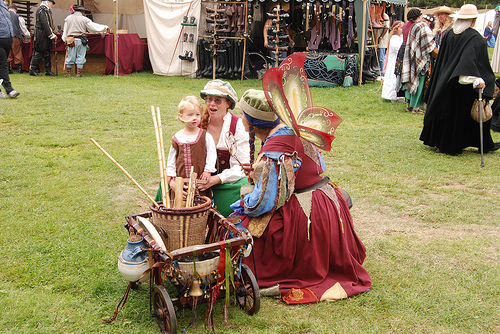

In [69]:
print(caption_image(img_test[150],transformer))
Image.open(img_test[150])



In [43]:
print(cap_inp_test[0])

[   3    1   19  136    5 2102    4  242    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [54]:
def calculate_bleu(ref,candidate):
    ref = ref.split()
    candidate = candidate.split()
    bleu_score = sentence_bleu(ref,candidate, weights = (0.5,0.5))
    return bleu_score

In [72]:
import nltk
import random
from nltk.translate.bleu_score import sentence_bleu

random.seed(200)
sampled_test = random.sample(img_test, 50)

total_bleu_score = 0
max_bleu_score = 0
for img in sampled_test:
    pred = caption_image(img,transformer)
    pred = tf.constant(pred)
    pred = pred.numpy().tolist()[0]
    pred = b' '.join(pred).decode('utf-8')

    for caps in image_path_to_caption[img]:
        bleu_score = calculate_bleu(caps,pred)
        max_bleu_score = max(max_bleu_score,bleu_score)
    total_bleu_score += max_bleu_score
    max_bleu_score = 0


In [75]:
print(total_bleu_score/len(sampled_test))

0.30926763790235656
